# Assignment 3 - Image Segmentation using MRFs

### Name : Karan Mirakhor  
### Roll No. 2018102034

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
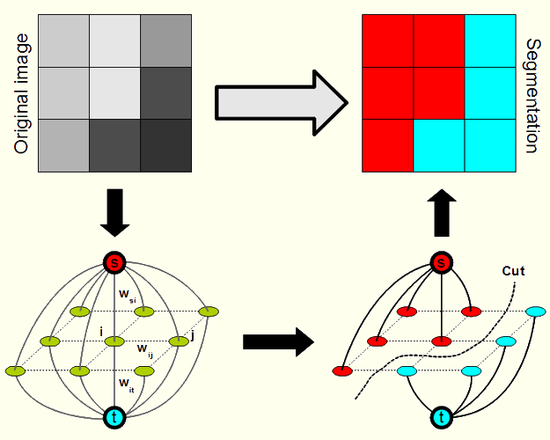

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [78]:
import numpy as np
import cv2
import igraph as ig
from sklearn.mixture import GaussianMixture as gmm
import matplotlib.pyplot as plt

In [79]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):
        
        black_x = []
        black_y = []

        # Draw the rectangle first
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = True
                self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['rect_over'] == False:
            
                self.FLAGS['DRAW_RECT'] = False
                self.FLAGS['rect_over'] = True
#                 cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                cv2.rectangle(self._mask, (self.ix, self.iy), (x, y), self.COLORS['RED'], 2)
#                 self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(x), abs(y))
                self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)


        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [3]:
def find_gmm(components,mask,img):
    model_init_fg = gmm(n_components=components,covariance_type='full')
    model_init_bg = gmm(n_components=components,covariance_type='full')
    fg_indices = np.where((mask==2) | (mask==3))
    bg_indices = np.where((mask==0) | (mask==1))
    model_fg = model_init_fg.fit(img[fg_indices])
    model_bg = model_init_bg.fit(img[bg_indices])
    return model_fg, model_bg


In [4]:
def calc_unary_energy(img,model,indices):
    pixels = img[indices]
    gmm_component_pixel = model.predict(img[indices])
    cov = model.covariances_[gmm_component_pixel]
    mean = model.means_[gmm_component_pixel]
    
    #weight_pixel
    weights = model.weights_[gmm_component_pixel]
    term_1 = -np.log(weights)
    
    #det_cov
    det_cov = np.linalg.det(cov)
    term_2 = 0.5*np.log(det_cov)
    
    #mean and cov
    mean_sub_pixel = pixels - mean
    cov_inv = np.linalg.inv(cov)
    term_3_i = np.einsum('ik,ikj->ij',mean_sub_pixel,cov_inv)
    term_3 = 0.5*np.einsum('ij,ij->i',term_3_i,mean_sub_pixel)

    U = term_1 + term_2 + term_3
    
    return U

In [5]:
def calc_internal_energy(img,gamma):
    
    left_neigh = img[:,1:] - img[:,:-1]
    up_neigh = img[1:,:] - img[:-1,:]
    sq_ln = left_neigh**2
    sq_un = up_neigh**2
    rows = img.shape[0]
    cols = img.shape[1]
    
    beta = np.sum(sq_ln) + np.sum(sq_un)    
    beta = (rows*cols)/beta
    
    V_l = gamma*np.exp(-beta*np.sum(sq_ln, axis=2))
    V_u = gamma*np.exp(-beta*np.sum(sq_un, axis=2))
    
    return V_l, V_u

In [6]:
def construct_background(img,model_fg,bg_nodes,bg_edge_weights,bg_terminal_node,mask):
    
    bg_prob_indices = np.where((mask==1)|(mask==2))
    bg_prob_weights = calc_unary_energy(img,model_fg,bg_prob_indices)
    
    bg_prob = np.where((mask.reshape(-1)==1)|(mask.reshape(-1)==2)) # Indices of the maybe background pixels
    bg = np.where((mask.reshape(-1)==0)) # Indices of the certain background pixels
    
    bg_nodes.extend(list(zip([bg_terminal_node]*bg[0].shape[0],bg[0])))
    bg_edge_weights.extend([np.inf]*bg[0].shape[0])
    bg_nodes.extend(list(zip([bg_terminal_node]*bg_prob[0].shape[0],bg_prob[0])))
    bg_edge_weights.extend(bg_prob_weights)
    return bg_nodes, bg_edge_weights 

def construct_foreground(img,model_bg,fg_nodes,fg_edge_weights,fg_terminal_node,mask):
    
    fg_prob_indices = np.where((mask==1)|(mask==2))
    fg_prob_weights = calc_unary_energy(img,model_bg,fg_prob_indices)
    
    fg_prob = np.where((mask.reshape(-1)==1)|(mask.reshape(-1)==2)) # Indices of the maybe foreground pixels
    fg = np.where((mask.reshape(-1)==3)) # Indices of the certain foreground pixels
    
    fg_nodes.extend(list(zip([fg_terminal_node]*fg[0].shape[0],fg[0])))
    fg_edge_weights.extend([np.inf]*fg[0].shape[0])
    fg_nodes.extend(list(zip([fg_terminal_node]*fg_prob[0].shape[0],fg_prob[0])))
    fg_edge_weights.extend(fg_prob_weights)
    return fg_nodes, fg_edge_weights 

def construct_internal_links(img,gamma,internal_nodes,internal_edge_weights):
    rows = img.shape[0]
    cols = img.shape[1]
    pixel_indices = np.arange(rows*cols,dtype=np.uint32).reshape(rows,cols)
    internal_nodes.extend(list(zip(pixel_indices[:,1:].reshape(-1), pixel_indices[:,:-1].reshape(-1))))
    internal_nodes.extend(list(zip(pixel_indices[1:,:].reshape(-1), pixel_indices[:-1,:].reshape(-1))))
    V_l, V_u = calc_internal_energy(img,gamma)
    internal_edge_weights.extend(V_l.reshape(-1))
    internal_edge_weights.extend(V_u.reshape(-1))
    return internal_nodes, internal_edge_weights 
    
def construct_graph(img,mask,components,gamma):
    model_fg, model_bg = find_gmm(components,mask,img)
    fg_terminal_node = img.shape[0]*img.shape[1]
    bg_terminal_node = img.shape[0]*img.shape[1] + 1
    rows = img.shape[0]
    cols = img.shape[1]
    graph_nodes = []
    graph_edge_weights = []
    
    ##Constructing graph with background terminal for sure background nodes
    bg_nodes = []
    bg_edge_weights = []
    bg_nodes, bg_edge_weights = construct_background(img,model_fg,bg_nodes,bg_edge_weights,bg_terminal_node,mask)
    graph_nodes.extend(bg_nodes)
    graph_edge_weights.extend(bg_edge_weights)
    
    ##Constructing graph with foreground terminal for sure background nodes
    fg_nodes = []
    fg_edge_weights = []
    fg_nodes, fg_edge_weights = construct_foreground(img,model_bg,fg_nodes,fg_edge_weights,fg_terminal_node,mask)
    graph_nodes.extend(fg_nodes)
    graph_edge_weights.extend(fg_edge_weights)
    
    ##Constructing the N-links
    internal_nodes = []
    internal_edge_weights = []
    internal_nodes, internal_edge_weights = construct_internal_links(img,gamma,internal_nodes,internal_edge_weights)
    graph_nodes.extend(internal_nodes)
    graph_edge_weights.extend(internal_edge_weights)
    
    grabcut_graph = ig.Graph(rows*cols+2)
    grabcut_graph.add_edges(np.array(graph_nodes))
    
    mincut = grabcut_graph.st_mincut(fg_terminal_node, bg_terminal_node, graph_edge_weights)
    fg_prob = np.where((mask == 2))  
    pixel_indices = np.arange(rows*cols,dtype=np.uint32).reshape(rows,cols)
    mask[fg_prob] = np.where(np.isin(pixel_indices[fg_prob], mincut.partition[0]), 2, 1)
    return mask

In [7]:
def grabcut(img,mask,components,gamma,iters=1):
    for _ in range(iters):
        mask = construct_graph(img,mask,components,gamma)
        img_op = img.copy()
        img_op = cv2.cvtColor(img_op, cv2.COLOR_BGR2RGB)
        img_op[(mask == 0)|(mask == 1)] = (0,0,0) 
        #plt.imshow(img_op)
        #plt.show()
    return mask, img_op

In [83]:
def run(filename: str,components,gamma):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 5}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 3}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    img_list = []
    mask_list = []
    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif . 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            rect_ = FLAGS['RECT']

            white_indices = np.where((mask==3))
            black_indices = np.where((mask==5))
            probblack_indices = np.where((mask==1))
            probwhite_indices = np.where((mask==2))

            mask[rect_[1]:rect_[3],rect_[0]:rect_[2]] = 2
            mask[white_indices] = 3
            mask[black_indices] = 0
            mask[probwhite_indices] = 2
            mask[probblack_indices] = 1
            mask_list.append(mask.copy())
            
            EventObj.mask, img_op = grabcut(img2,mask,components,gamma,iters=1)
            
            img_list.append(img_op)
            FLAGS['rect_or_mask'] = 1
                
        EventObj.flags = FLAGS
        mask2 = np.where((mask==2)|(mask == 3), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)
    return mask_list, img_list

In [69]:
def plot(mask_list, img_list):
    n = len(mask_list)
    f, arr = plt.subplots(n,2,figsize=(16, 8*n))
    if n==1 :
        arr[0].imshow(mask_list[0],cmap='gray')
        arr[1].imshow(img_list[0])
        arr[0].set_title("Iteration 1")
        arr[1].set_title("Iteration 1")
    else :
        for i in range(n):
            arr[i,0].imshow(mask_list[i],cmap='gray')
            arr[i,0].set_title("Iteration "+str(i))
            arr[i,1].imshow(img_list[i])
            arr[i,1].set_title("Iteration "+str(i))

# Changing components of GMM

- We train GMM with multiple mutivariate gaussian components to perfectly fit the color space of the image.
- We need more components than the color patches in a image to perfectly fit the Gaussian

## doll.jpg

### With GMM = 1

Draw the rectangle first.


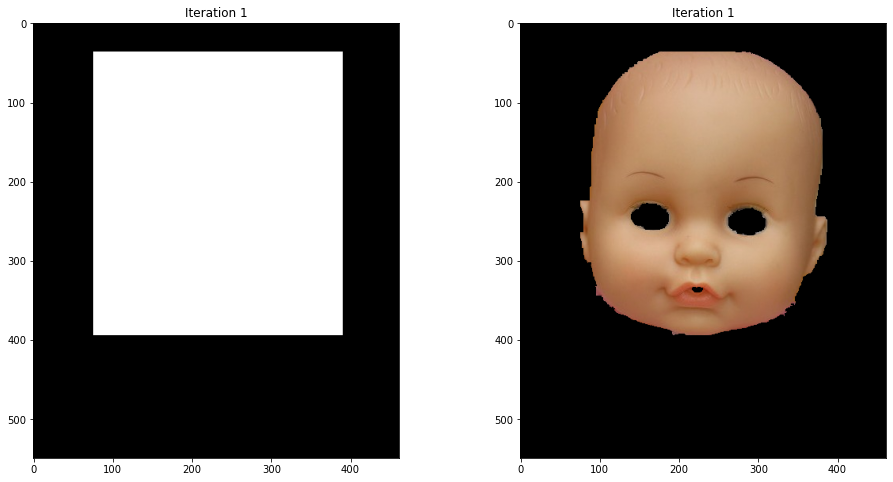

In [88]:
if __name__ == '__main__':
    filename = '../images/doll.jpg'  # Path to image file
    mask_list, img_list = run(filename,1,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

### With GMM = 4

Draw the rectangle first.


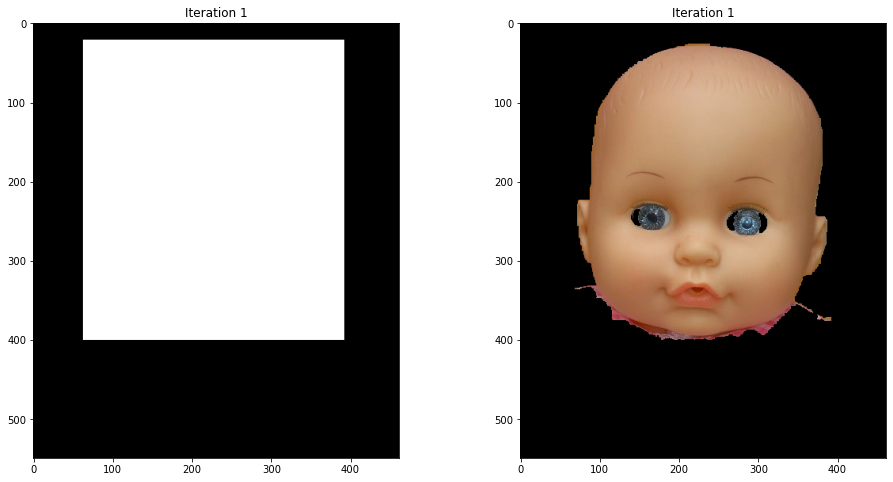

In [116]:
if __name__ == '__main__':
    filename = '../images/doll.jpg'  # Path to image file
    mask_list, img_list = run(filename,4,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

### With GMM = 7

Draw the rectangle first.


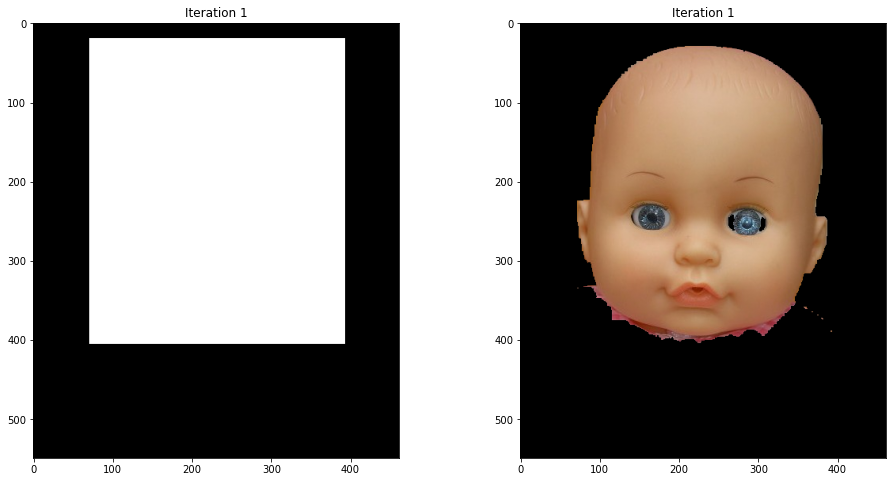

In [117]:
if __name__ == '__main__':
    filename = '../images/doll.jpg'  # Path to image file
    mask_list, img_list = run(filename,7,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

### With GMM = 10

Draw the rectangle first.


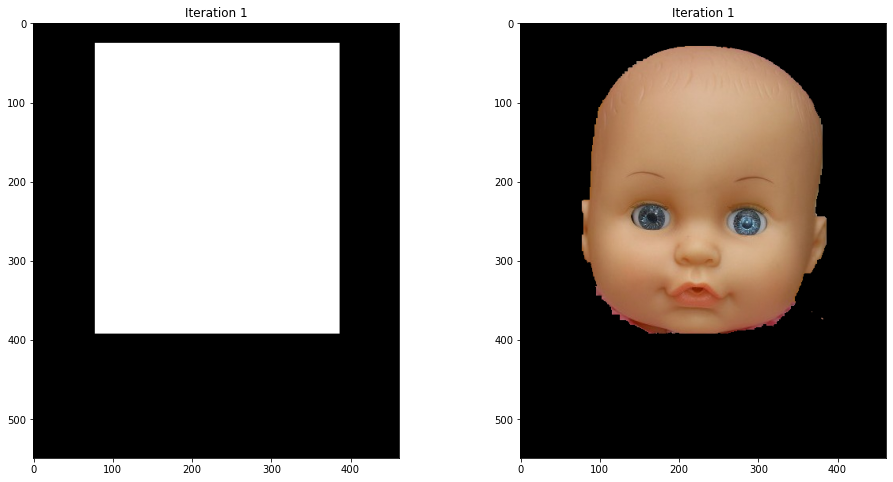

In [89]:
if __name__ == '__main__':
    filename = '../images/doll.jpg'  # Path to image file
    mask_list, img_list = run(filename,10,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

# Changing Gamma

- Gamma is the weight of the smoothness function.
- Hence, higher gamma means a higher cost for smoothness which leads to very strict segmentation of stray pixels into foreground or background.
- A lower gamma will lead to a lower cost and thus more stray pixels get segmented as foreground or background.

## banana1.jpg

### With Gamma = 50

Draw the rectangle first.


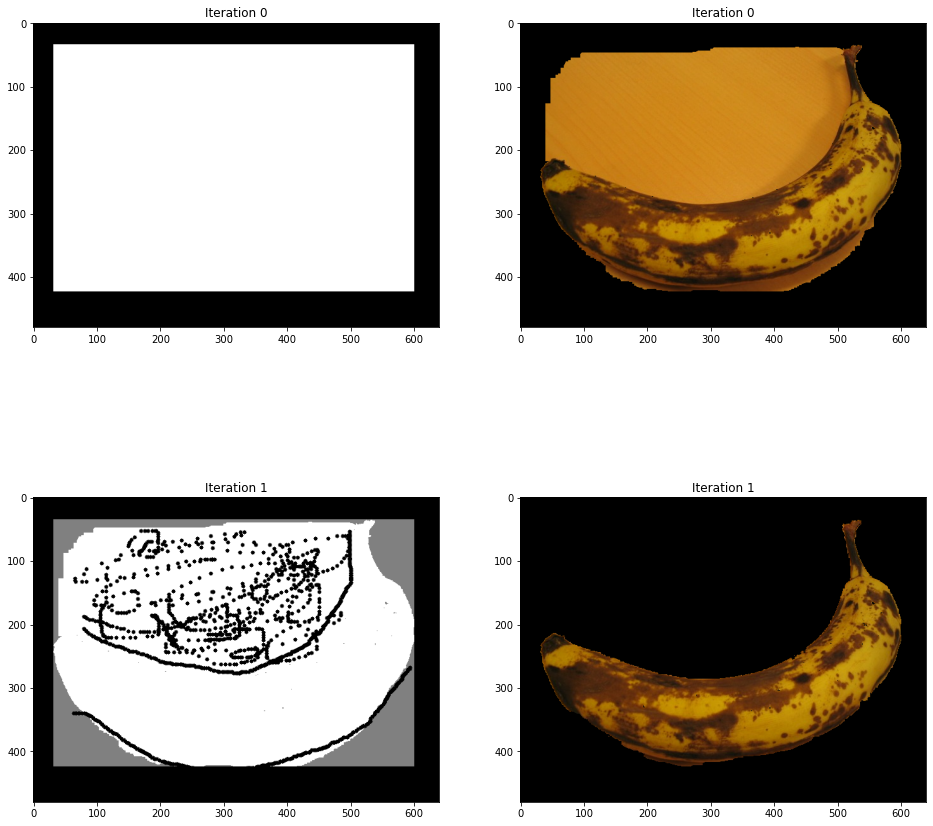

In [70]:
if __name__ == '__main__':
    filename = '../images/banana1.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

### With Gamma = 5000

Draw the rectangle first.


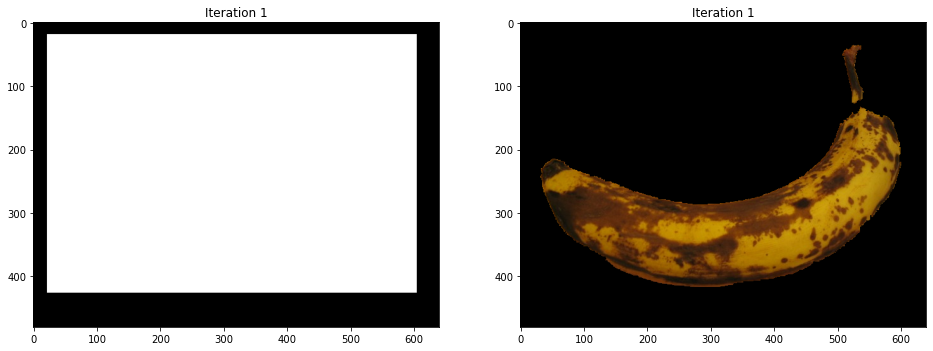

In [97]:
#Gamma = 5000
if __name__ == '__main__':
    filename = '../images/banana1.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,5000)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

## stone1.jpg

### With Gamma = 50

Draw the rectangle first.


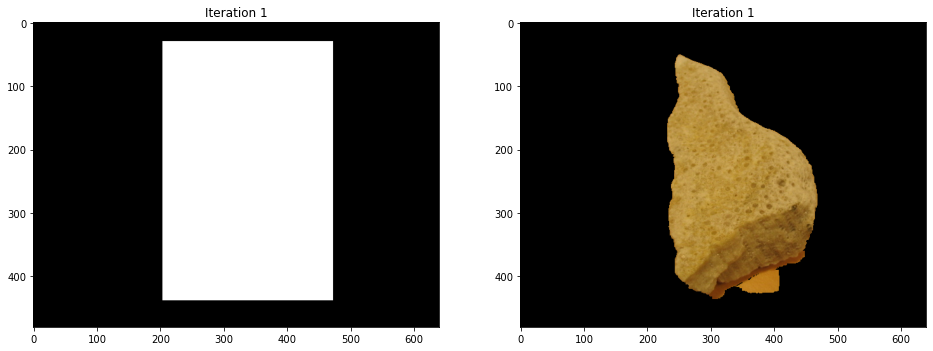

In [99]:
#Gamma = 50
if __name__ == '__main__':
    filename = '../images/stone1.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

### With Gamma = 5000

Draw the rectangle first.


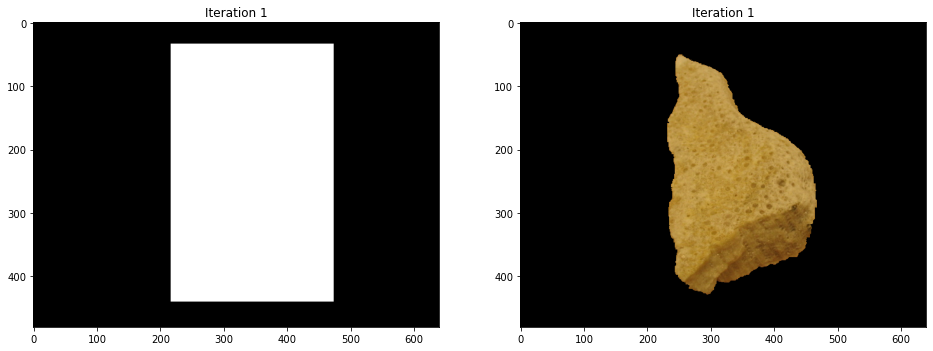

In [98]:
#Gamma = 5000
if __name__ == '__main__':
    filename = '../images/stone1.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,5000)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

### With Gamma = 50

Draw the rectangle first.


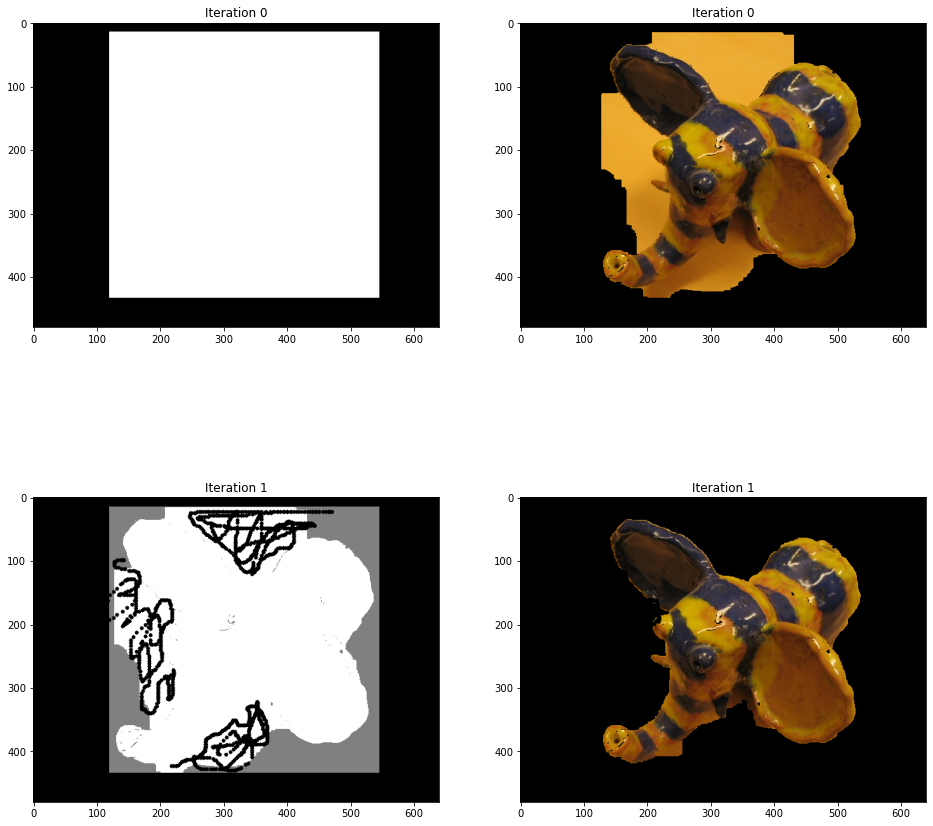

In [106]:
if __name__ == '__main__':
    filename = '../images/ceramic.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

### With Gamma  = 1500

Draw the rectangle first.


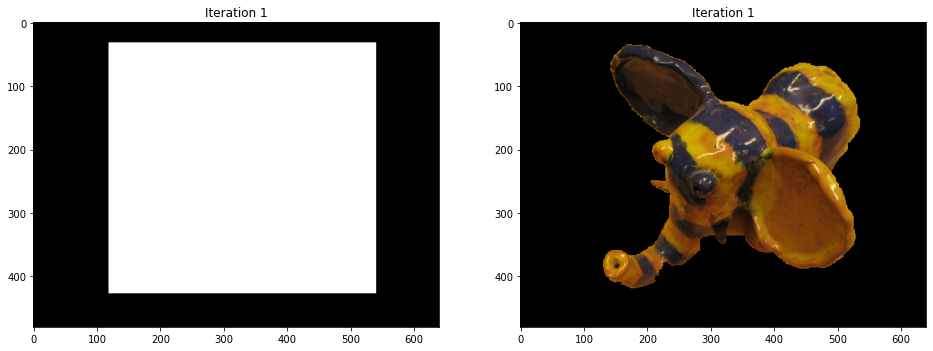

In [110]:
if __name__ == '__main__':
    filename = '../images/ceramic.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,1000)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

# Effect of a loose bounding box or tight initial bounding box

- A tight bounding box heps us the decide the background for sure as the algorithm assumes that region outside is a background for sure
- These background pixels can be used to fit GMM for the background which will further help in deciding the uncertain pixel within the box as foreground or background. 
- A loose bounding box on the other hand will not be able to capture this information about the background pixels hence the GMM model does not fit properly which makes it difficult to decide on the uncertain pixel as foreground or background.

## person6.jpg

### Loose Bounding Box

Draw the rectangle first.


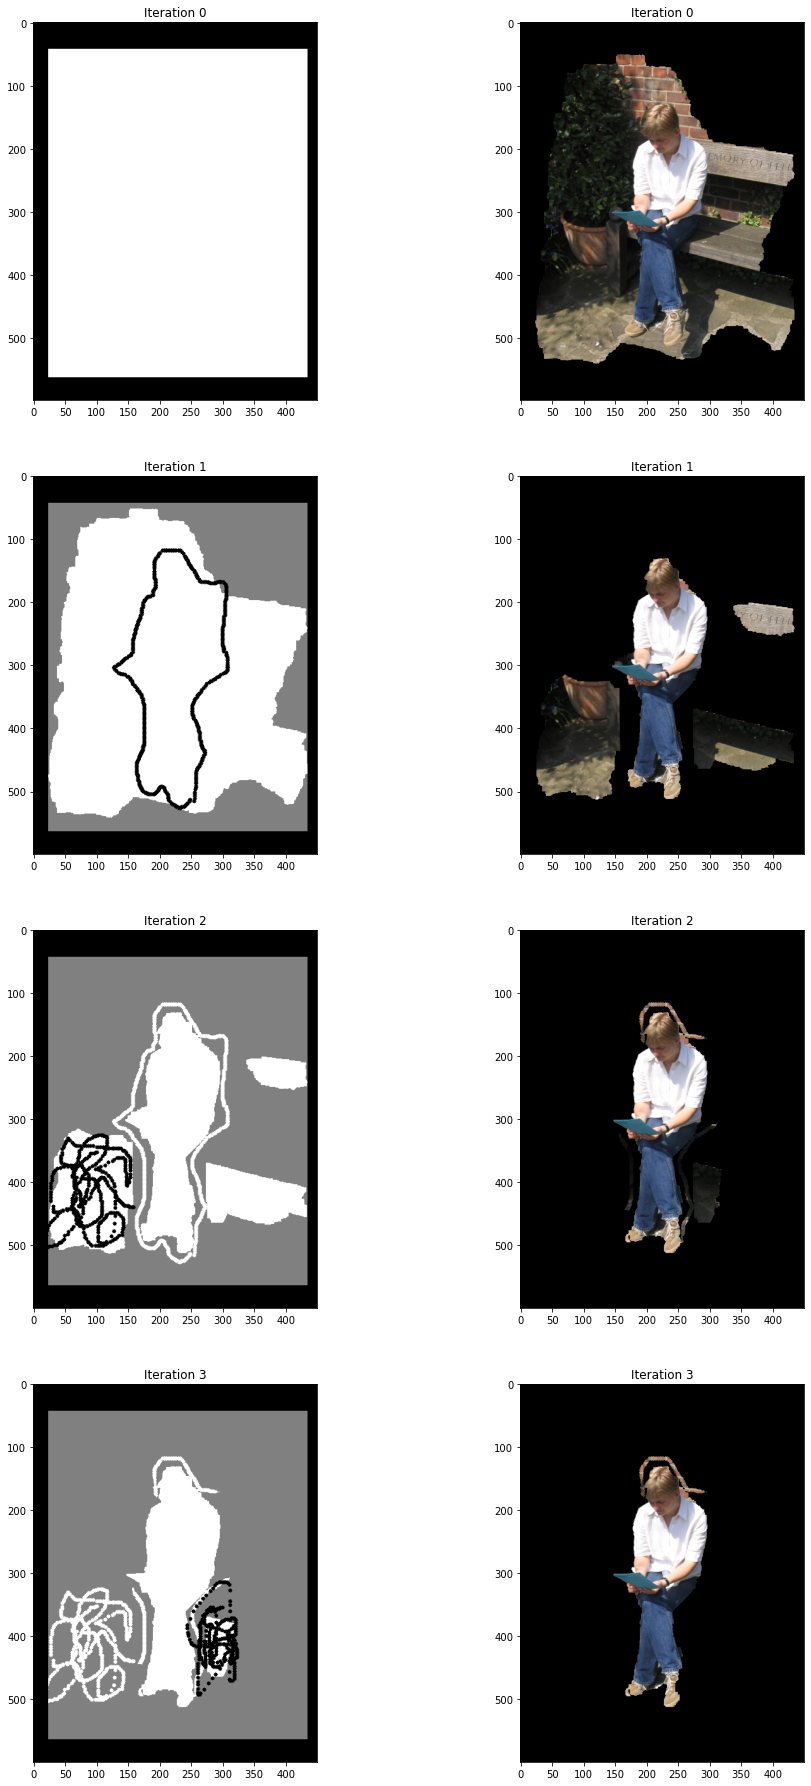

In [130]:
if __name__ == '__main__':
    filename = '../images/person6.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

### Tight Bounding Box

Draw the rectangle first.


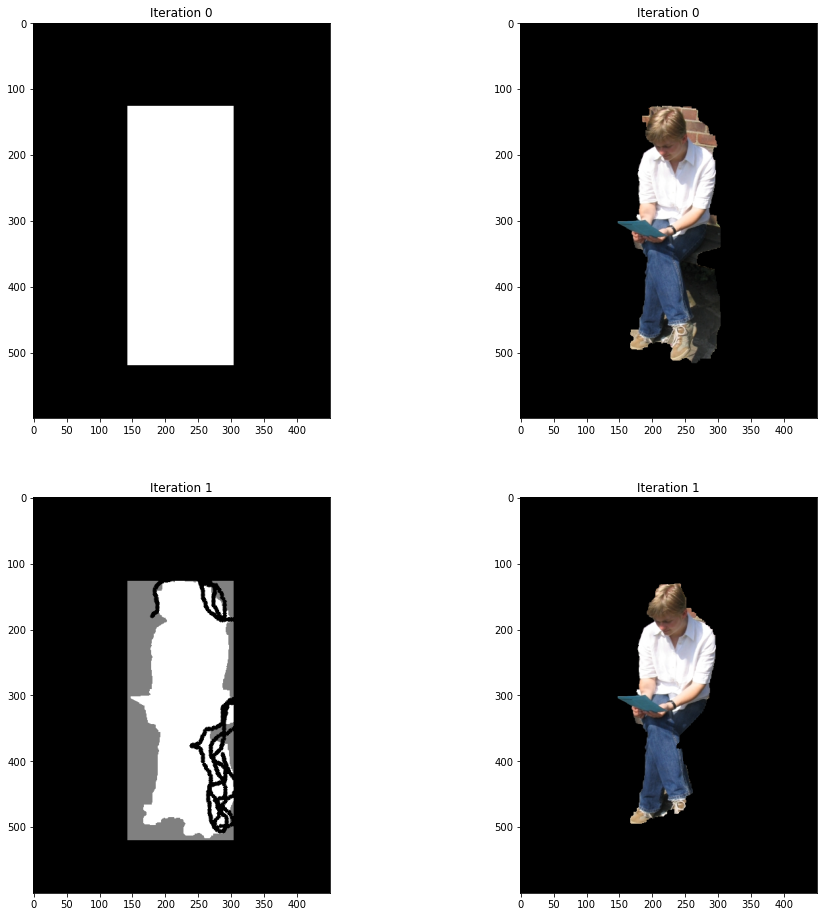

In [131]:
if __name__ == '__main__':
    filename = '../images/person6.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

## person3.jpg

### Loose Bounding Box

Draw the rectangle first.


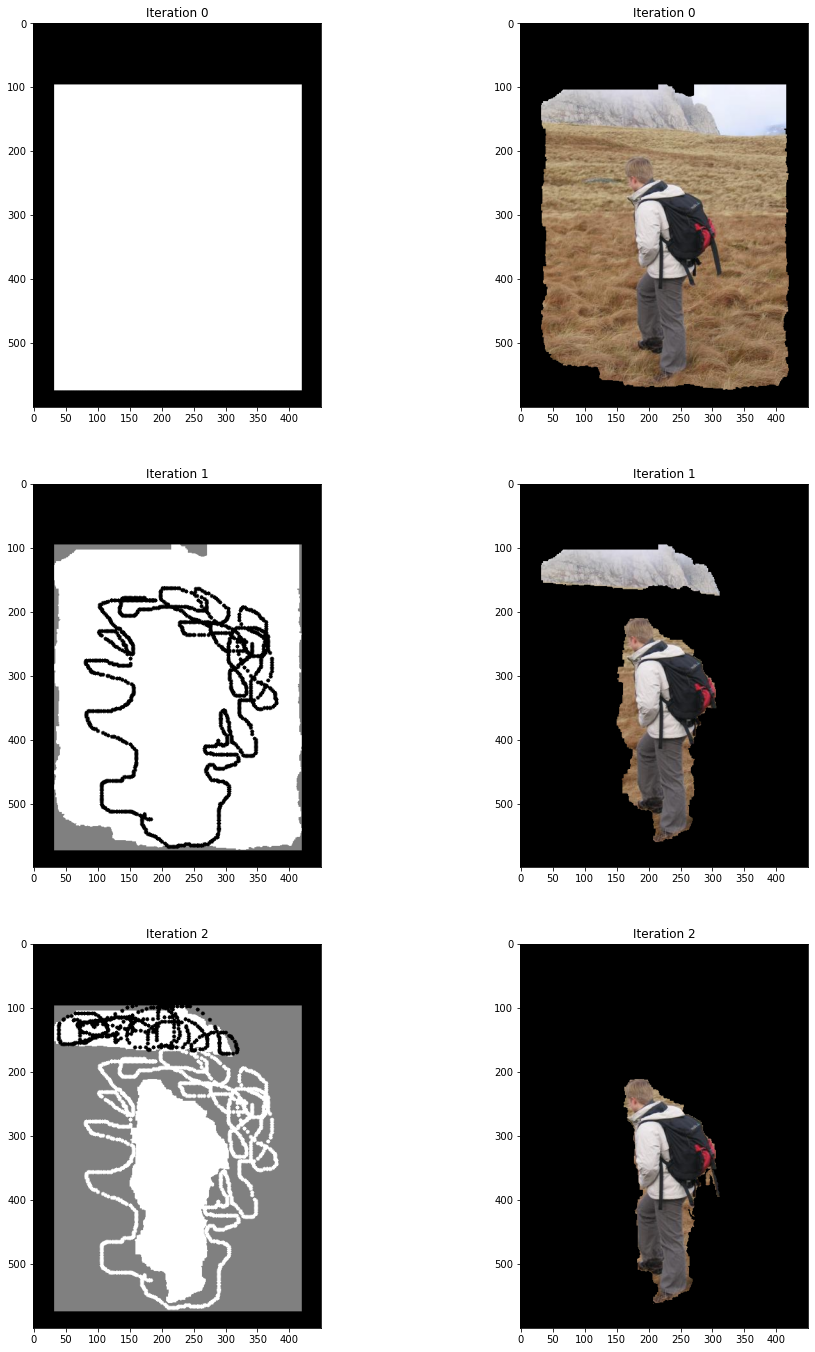

In [127]:
if __name__ == '__main__':
    filename = '../images/person3.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

### Tight Bounding Box

Draw the rectangle first.


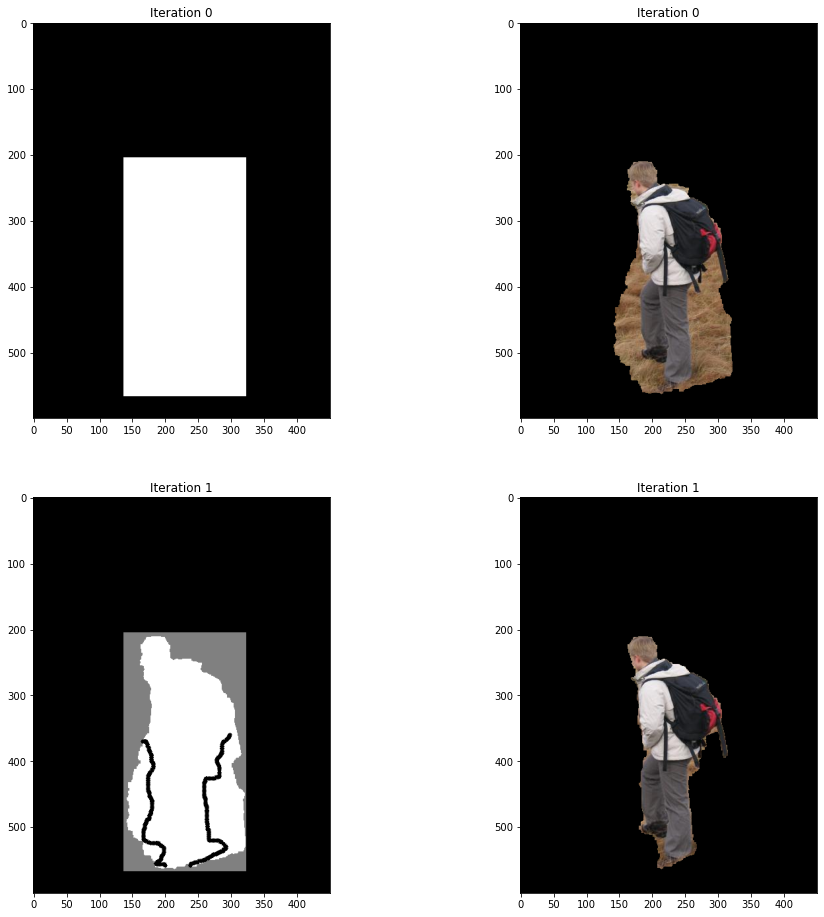

In [128]:
if __name__ == '__main__':
    filename = '../images/person3.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

# Scribbling on images where tight bounding box does not suffice

- Scribbling the images gives more information about the certain background and foreground pixels which helps the GMM to better fit the model that leads to better segmentation  

## Banana2.jpg

Draw the rectangle first.


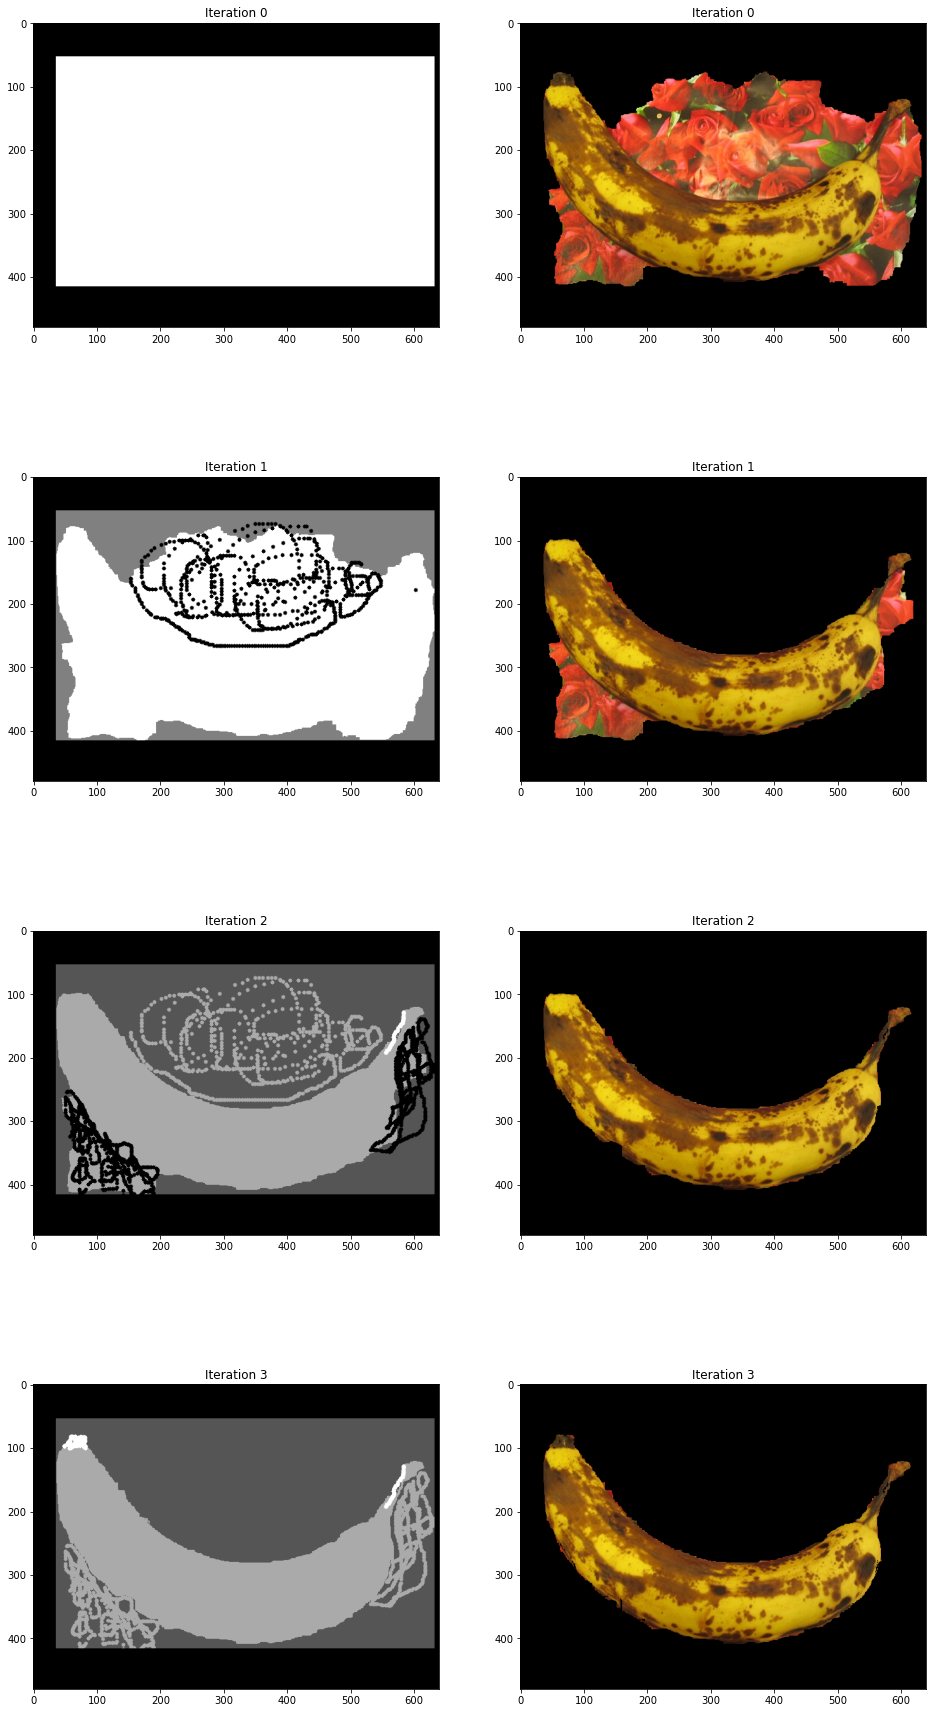

In [111]:
if __name__ == '__main__':
    filename = '../images/banana3.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

## llama.jpg

Draw the rectangle first.


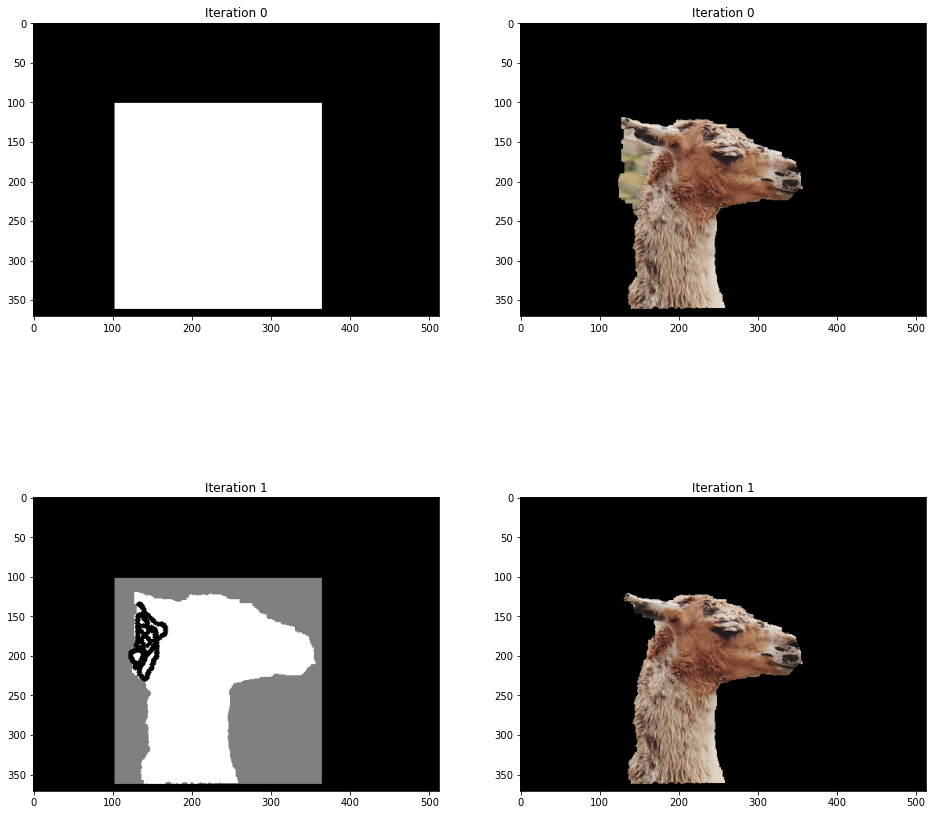

In [112]:
if __name__ == '__main__':
    filename = '../images/llama.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

Draw the rectangle first.


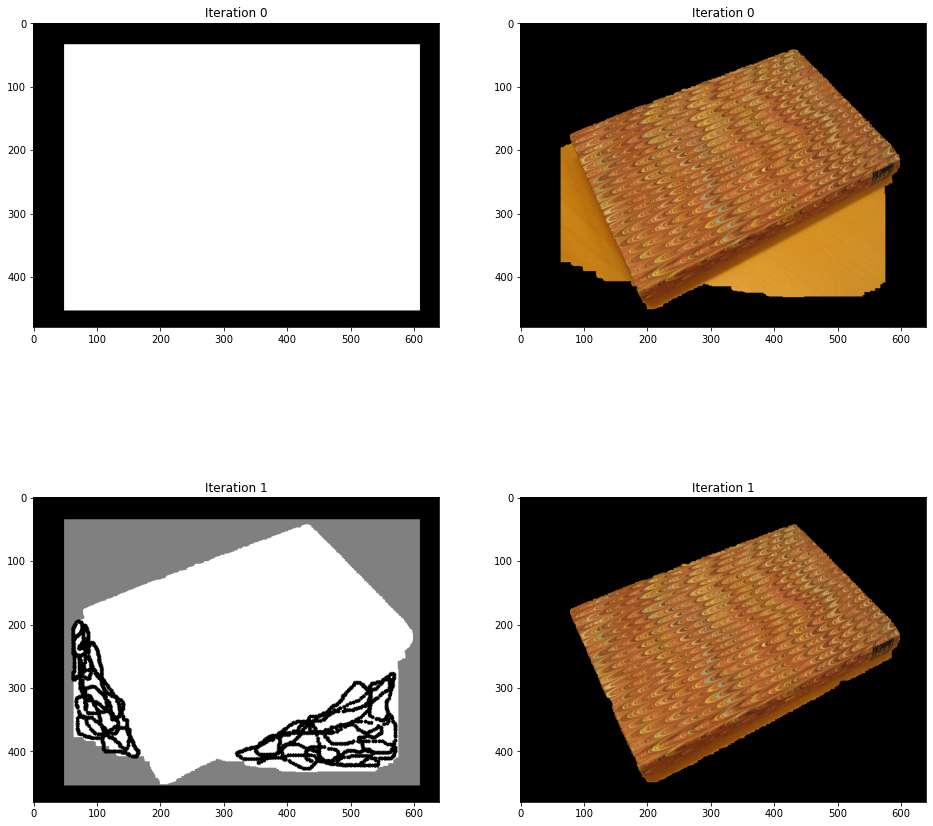

In [114]:
if __name__ == '__main__':
    filename = '../images/book.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

# Images that work with just a tight Bounding box

- Some images have objects which do not share any overlapping color spaces with the surrounding such images can be easily segmented just using a proper bounding box

## flower.jpg

Draw the rectangle first.


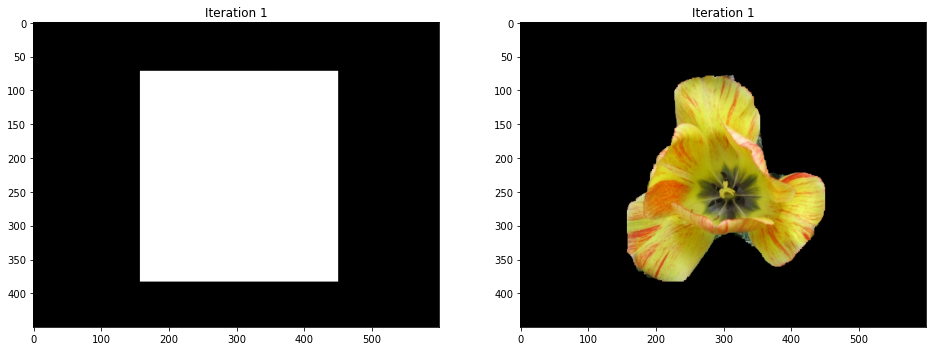

In [72]:
if __name__ == '__main__':
    filename = '../images/flower.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

## person2.jpg

Draw the rectangle first.


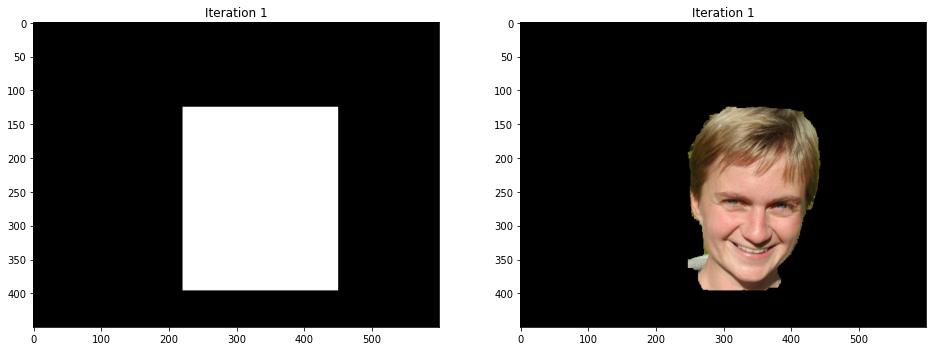

In [75]:
if __name__ == '__main__':
    filename = '../images/person2.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)

## teddy.jpg

Draw the rectangle first.


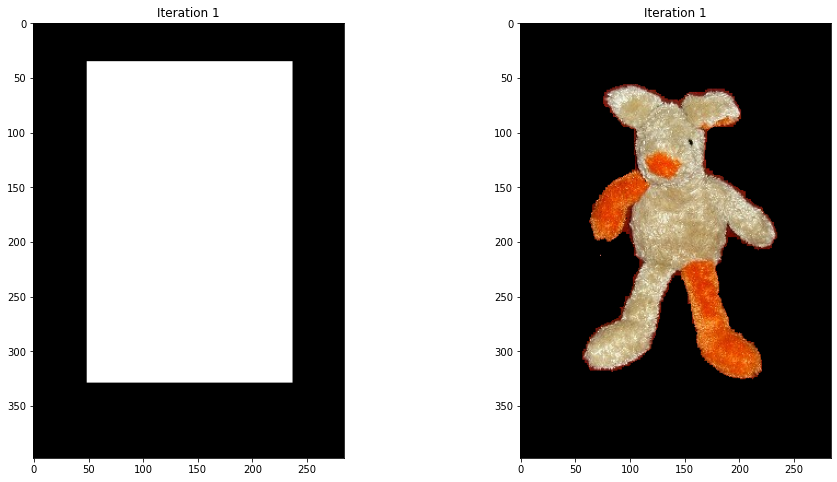

In [71]:
if __name__ == '__main__':
    filename = '../images/teddy.jpg'  # Path to image file
    mask_list, img_list = run(filename,5,50)
    cv2.destroyAllWindows()
    plot(mask_list, img_list)